In [1]:
import os
import matplotlib
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import WCSAxes
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy.coordinates import SkyCoord
from reproject import reproject_interp
from spectral_cube import SpectralCube
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.nddata.utils import Cutout2D
import astropy.units as u
from astropy.coordinates import Angle, Latitude, Longitude
import math
import scipy.constants
from astropy import units as u

from reproject import reproject_interp

# imports Danya included
from matplotlib.colors import LogNorm
from astropy.coordinates import match_coordinates_sky
from astropy.convolution import Gaussian2DKernel
from scipy.signal import convolve as scipy_convolve
from astropy.convolution import convolve, convolve_fft
from astropy.convolution import interpolate_replace_nans
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, LogNorm
import matplotlib.colors
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d
#import plotly.graph_objects as go
import skimage.measure as measure
import skimage as ski
from skimage.draw import polygon2mask

from mpl_toolkits.mplot3d.axes3d import Axes3D

# Imports for RGB from Perry
import matplotlib.patheffects as pe
from astropy.visualization import make_lupton_rgb
from astropy.visualization import (MinMaxInterval, PercentileInterval, LogStretch, LinearStretch, ImageNormalize)
plt.rcParams['text.usetex'] = True

In [6]:
xray = 'Xray_Clavel_chandra_pigs_cube_smoothed_4k_updated_stone_only.fits'
hdu_xray      = fits.open(xray)[0]
wcs_xray = WCS(hdu_xray.header)

wcs_xray_2axis=wcs_xray.dropaxis(2)
# cmzoom = "cmzoom_cutout.regrid.fits"
# hdu_cmzoom      = fits.open(cmzoom)[0]
# wcs_cmzoom = WCS(hdu_cmzoom.header)

file_xray_cropped_s=open_files('Xray_Clavel_chandra_pigs_cube_smoothed_4k_updated_stone_only.fits')
hdu_xray_cropped_s,wcs_xray_cropped_s=file_xray_cropped_s

cmzoom = "cmzoom_cutout.regrid.fits"
hdu_cmzoom      = fits.open(cmzoom)[0]
wcs_cmzoom = WCS(hdu_cmzoom.header)


herschel = "Herschel_data/higalcmz_column_density_source_only_inner7deg.fits"
herschel = "data/herschel_column.fits"
hdu_herschel    = fits.open(herschel)[0]
wcs_herschel = WCS(hdu_herschel.header)
### load in the fits hdus for each file
### this assumes all data are 2D and on the same pixel grid.

### f1 becomes blue
### f2 becoms green
### f3 becomes red
region1_f1_hdus = fits.open('non_pb_corrected_from_dan_G0.068-0.075.H2CO.218.2GHz_integrated.fits')
region1_f2_hdus = fits.open('non_pb_corrected_from_dan_G0.068-0.075.H2CO.218.5GHz_integrated.fits')
region1_f3_hdus = fits.open('non_pb_corrected_from_dan_G0.068-0.075.SiO.217.1GHz_integrated.fits')
hdu_h2co = fits.open('non_pb_corrected_from_dan_G0.068-0.075.H2CO.218.2GHz_integrated.fits')
### construct the wcs from one of them (they should all be the same, right?)
r1wcs = WCS(region1_f1_hdus[0])



In [5]:
def open_files(file):
    filename = file
    hdu  = fits.open(filename)[0]
    wcs=WCS(hdu.header)
    if hdu.header['NAXIS']==3:
        wcs=wcs.dropaxis(2)
    return hdu, wcs

In [ ]:
def single_coord(file,coord):
    hdu,wcs=file 
    pos = SkyCoord(frame="galactic", l=coord[0], b=coord[1], unit=(u.deg))
    x, y = wcs.world_to_pixel(pos)
    return (x, y)

## Creating monster mask!

In [7]:
xray_start= 9
num_years=8
mask_list=[]

for year in range(num_years):
    contours = measure.find_contours(hdu_xray.data[xray_start+year], 3e-9)
    for i in contours:
        if min(i[:,1])>25:
            mask = ski.draw.polygon2mask(hdu_xray.data[xray_start+year].shape, i)
            mask_tot=mask.astype(int)
            mask_list.append(mask_tot)


mask_tot = np.zeros(np.shape(hdu_xray.data[0]))
for year in range(len(mask_list)):
    mask_tot += mask_list[year]
    
mask_tot[mask_tot > 0] = 1
    
result = mask_tot

len_xray = 17

for i in range(9, len_xray, 1):
    if i == 11:
        xray_int = hdu_xray.data[i]
        #print(i)
    else:
        xray_int = xray_int + hdu_xray.data[i]

header = wcs_xray_2axis.to_header()
mask_hdu = fits.PrimaryHDU(result,header)
hdu_masked = fits.HDUList(mask_hdu)
hdu_masked.writeto('stone_cloud_4k_monster_mask.fits', overwrite=True)

In [14]:
# Plotting point for x-ray max
max_xray_pos = SkyCoord(frame="galactic", l=0.05625775, b=-0.07799004, unit=(u.deg))
max_hersch_pos = SkyCoord(frame="galactic", l=0.06504434, b= -0.0778928, unit=(u.deg))
x_max_hersch, y_max_hersch = wcs_cmzoom.world_to_pixel(max_hersch_pos)
x_max_xray, y_max_xray = wcs_herschel.world_to_pixel(max_xray_pos)
cmzoom_max = wcs_cmzoom.pixel_to_world(722.2975164093286,  296.3324970320718)
max_cmzoom_pos = SkyCoord(frame="galactic", l=0.07324034, b=-0.07359138, unit=(u.deg))
print(x_max_xray, y_max_xray)
print(x_max_hersch, y_max_hersch)
print(max_hersch_pos)
print(cmzoom_max)


1094.7504809060595 391.96959359742914
781.3105538278996 265.36119856412984
<SkyCoord (Galactic): (l, b) in deg
    (0.06504434, -0.0778928)>
<SkyCoord (Galactic): (l, b) in deg
    (0.07324034, -0.07359138)>


In [7]:
#h2co_filename = get_pkg_data_filename("G0.068-0.075.H2CO.218.2GHz.fits")
#h2co_hdu      = fits.open(h2co_filename)[0]
#h2co_wcs = WCS(h2co_hdu.header)

h2co_spec = fits.open('G0.068-0.075.H2CO.218.2GHz.fits')
h2co_cube = SpectralCube.read(h2co_spec) 
h2co_spec.close()

/var/folders/8n/_rhj_p6j11j3hj9wn3tzy0280000gn/T/ipykernel_17202/116684560.py:43: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(141, projection=r1wcs)
/Users/danyaalboslani/opt/anaconda3/lib/python3.8/site-packages/astropy/visualization/wcsaxes/core.py:254: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)
/Users/danyaalboslani/opt/anaconda3/lib/python3.8/site-packages/astropy/visualization/wcsaxes/core.py:254: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)
/var/folders/8n/_rhj_p6j11j3hj9wn3tzy0280000gn/T/ipykernel_17202/116684560.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(pad=0.2, w_pad=0.2, h_pad=0.05)
/Users/danyaalbosl

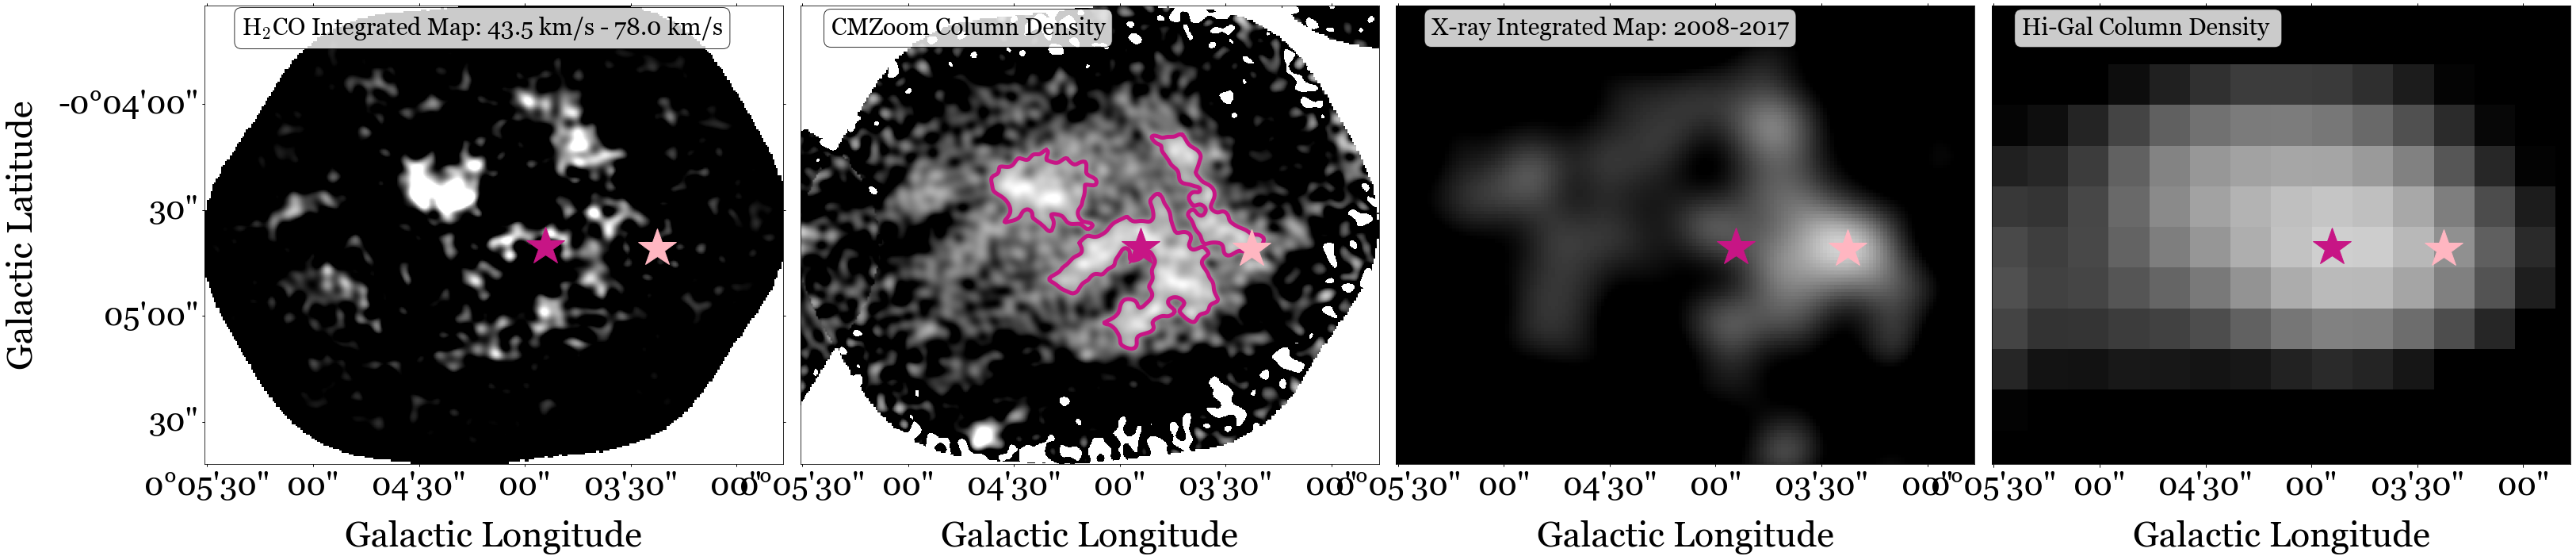

In [96]:
fig_integrated, axes = plt.subplots(figsize=(45,35))
matplotlib.rcParams['font.sans-serif'] = "georgia" 
matplotlib.rcParams['mathtext.fontset'] = "cm" 
title_size=45
tick_size=40
label_size=30
x_min=0
x_max=328
y_min=0
y_max=260
hersch_color='mediumvioletred'
xray_color='lightpink'
# Extract coordinates from the second column for cropping
middle_cube = 'non_pb_corrected_from_dan_G0.068-0.075.SiO.217.1GHz_integrated.fits'
middle_wcs = r1wcs
# Get the pixel limits for the second column

# getting the original colormap using cm.get_cmap() function 
orig_map=plt.cm.get_cmap('gray') 
  
# reversing the original colormap using reversed() function 
reversed_map = orig_map.reversed()

# getting the original colormap using cm.get_cmap() function 
orig_map_v=plt.cm.get_cmap('viridis') 
  
# reversing the original colormap using reversed() function 
reversed_map_v = orig_map_v.reversed()

# Convert pixel coordinates to world coordinates for column 2
ra_min, dec_min = middle_wcs.all_pix2world(x_min, y_min, 0)
ra_max, dec_max = middle_wcs.all_pix2world(x_max, y_max, 0)

### Ok here's the fun part: we need to find a normalization for each color that makes it look
### good. This can be tricky, so try messing around with it for your images.
### Chances are, the default won't be great for you unless you're very lucky.
b = ImageNormalize(region1_f1_hdus[0].data,stretch=LogStretch(a=10),vmin=1.6, vmax=5.18, clip=True)(region1_f1_hdus[0].data) # LogStretch(a=50),vmin=0.8
g = ImageNormalize(region1_f2_hdus[0].data,stretch=LogStretch(a=10),vmin=1.6, vmax=3.03, clip=True)(region1_f2_hdus[0].data) # vmax=3.03
r = ImageNormalize(region1_f3_hdus[0].data,stretch=LogStretch(a=10),vmin=1.6, vmax=3.49, clip=True)(region1_f3_hdus[0].data) # vmax=3.49


#cmzoom with monster mask
ax = plt.subplot(141, projection=r1wcs)
lon = ax.coords[0]
lat = ax.coords[1]
### here's the call to actually make the rgb figure using make_lupton_rgb instead of aplpy
rgb_default = make_lupton_rgb(r, g, b,stretch=1,Q=1.0) # minimum=[0.24, 0.08, 0.24]
### Now actually show the grid using imshow
#ax.imshow(rgb_default, origin='lower')
ax.imshow(region1_f1_hdus[0].data,origin='lower',cmap='gray',vmin=0.6,vmax=4)
contours=measure.find_contours(hdu_cmzoom.data, 9e7)
ax.contour(result,levels=1, transform=ax.get_transform(wcs_xray_2axis),colors=xray_color,linewidths=3)
for i in contours:
        if i[0,1]>500 and max(i[:,1])-min(i[:,1])>30:
            ax.plot(i[:, 1], i[:, 0], linewidth=5, color=hersch_color,transform=ax.get_transform(wcs_cmzoom))
ax.plot_coord(max_hersch_pos ,'*', c=hersch_color, markersize=50)
ax.plot_coord(max_xray_pos, '*', c=xray_color, markersize=50,linewidth=6)

### Now I add just some nice path effects to make the label text legible
### I suggest changing out the frequency labels for the frequencies of your images

ax.set_ylabel('Galactic Latitude',fontsize=title_size)
lat.set_ticklabel(size=tick_size)
lon.set_ticklabel(size=tick_size)
ax.set_xlabel('Galactic Longitude',fontsize=title_size)
ax.text(.48, .95, r'H$_2$CO Integrated Map: 43.5 km/s - 78.0 km/s', ha='center', va='center', transform=ax.transAxes,
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='k', alpha=.8), fontsize=label_size)
plt.tight_layout(pad=0.2, w_pad=0.2, h_pad=0.05)

ax = plt.subplot(142, projection=wcs_cmzoom)
lon = ax.coords[0]
lat = ax.coords[1]
ax.imshow(hdu_cmzoom.data,norm=LogNorm(vmin=4e7,vmax=1.5e8),cmap='gray')
contours=measure.find_contours(hdu_cmzoom.data, 9e7)
for i in contours:
        if i[0,1]>500 and max(i[:,1])-min(i[:,1])>30:
            ax.plot(i[:, 1], i[:, 0], linewidth=5, color=hersch_color,transform=ax.get_transform(wcs_cmzoom))
ax.plot_coord(max_hersch_pos, '*', c=hersch_color, markersize=50)
ax.plot_coord(max_xray_pos, '*', c=xray_color, markersize=50,linewidth=6)

ax.contour(result,levels=1, transform=ax.get_transform(wcs_xray_2axis),colors=xray_color,linewidths=3)
x_min_new, y_min_new = wcs_cmzoom.all_world2pix(ra_min, dec_min, 0)
x_max_new, y_max_new = wcs_cmzoom.all_world2pix(ra_max, dec_max, 0)
ax.set_xlim(x_min_new, x_max_new)
ax.set_ylim(y_min_new, y_max_new)
lat.set_ticks_visible(False)
lat.set_ticklabel_visible(False)
lat.set_axislabel('')
lon.set_ticklabel(size=tick_size)
ax.set_xlabel('Galactic Longitude',fontsize=title_size)
ax.text(.29, .95, 'CMZoom Column Density', ha='center', va='center', transform=ax.transAxes,
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='k', alpha=.8), fontsize=label_size)

ax = plt.subplot(143, projection=wcs_xray_2axis)
lon = ax.coords[0]
lat = ax.coords[1]
ax.imshow(xray_int,cmap='gray',vmin=9.9e-9,vmax=3e-8)
contours=measure.find_contours(hdu_cmzoom.data, 9e7)
for i in contours:
        if i[0,1]>500 and max(i[:,1])-min(i[:,1])>30:
            ax.plot(i[:, 1], i[:, 0], linewidth=5, color=hersch_color,transform=ax.get_transform(wcs_cmzoom))

ax.contour(result,levels=1, transform=ax.get_transform(wcs_xray_2axis),colors=xray_color,linewidths=3)
ax.plot_coord(max_xray_pos, '*', c=xray_color, markersize=50,linewidth=6)
lon.set_ticklabel(size=tick_size)
ax.set_xlabel('Galactic Longitude',fontsize=title_size)
lat.set_ticks_visible(False)
lat.set_ticklabel_visible(False)
lat.set_axislabel('')
x_min_new, y_min_new = wcs_xray_2axis.all_world2pix(ra_min, dec_min, 0)
x_max_new, y_max_new = wcs_xray_2axis.all_world2pix(ra_max, dec_max, 0)
ax.set_xlim(x_min_new, x_max_new)
ax.set_ylim(y_min_new, y_max_new)
ax.plot_coord(max_hersch_pos, '*', c=hersch_color, markersize=50)
ax.text(0.37, 0.95, 'X-ray Integrated Map: 2008-2017', ha='center', va='center', transform=ax.transAxes,
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='k', alpha=.8), fontsize=label_size)

plt.tight_layout(pad=0.2, w_pad=0.2, h_pad=0.05)

ax = plt.subplot(144, projection=wcs_herschel)
lon = ax.coords[0]
lat = ax.coords[1]
ax.imshow(hdu_herschel.data, norm='log', vmin=6e22,vmax=2e23,cmap='gray')
contours=measure.find_contours(hdu_cmzoom.data, 9e7)
for i in contours:
        if i[0,1]>500 and max(i[:,1])-min(i[:,1])>30:
            ax.plot(i[:, 1], i[:, 0], linewidth=5, color=hersch_color,transform=ax.get_transform(wcs_cmzoom))
ax.plot_coord(max_xray_pos, '*', c=xray_color, markersize=50)
ax.plot_coord(max_hersch_pos ,'*', c=hersch_color, markersize=50)

ax.contour(result,levels=1, transform=ax.get_transform(wcs_xray_2axis),colors=xray_color,linewidths=3)
ax.set_xlabel('Galactic Longitude',fontsize=title_size)
lon.set_ticklabel(size=tick_size)
lat.set_ticklabel(size=tick_size)
lat.set_ticks_visible(False)
lat.set_ticklabel_visible(False)
lat.set_axislabel('')
x_min_new, y_min_new = wcs_herschel.all_world2pix(ra_min, dec_min, 0)
x_max_new, y_max_new = wcs_herschel.all_world2pix(ra_max, dec_max, 0)
ax.set_xlim(x_min_new, x_max_new)
ax.set_ylim(y_min_new, y_max_new)
ax.text(0.27, 0.95, 'Hi-Gal Column Density ', ha='center', va='center', transform=ax.transAxes,
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='k', alpha=0.8), fontsize=label_size)
#ax.plot(max_xray_pos, marker='*')

plt.tight_layout(pad=0.2, w_pad=0.2, h_pad=0.05)


In [24]:
xray = "Xray_Clavel_chandra_pigs_cube_smoothed_4k_updated_stone_only.fits"
hdu_xray      = fits.open(xray)[0]
wcs_xray = WCS(hdu_xray.header)

wcs_xray_2axis=wcs_xray.dropaxis(2)
# cmzoom = "cmzoom_cutout.regrid.fits"
# hdu_cmzoom      = fits.open(cmzoom)[0]
# wcs_cmzoom = WCS(hdu_cmzoom.header)


cmzoom = "cmzoom_cutout.regrid.fits"
hdu_cmzoom      = fits.open(cmzoom)[0]
wcs_cmzoom = WCS(hdu_cmzoom.header)

cmzoom_cutout = "datass/CMZoom_continuum_pbcor.fits"
hdu_cmzoom_cutout      = fits.open(cmzoom)[0]
wcs_cmzoom_cutout = WCS(hdu_cmzoom.header)

herschel = "Herschel_data/higalcmz_column_density_source_only_inner7deg.fits"
herschel = "data/herschel_column.fits"
hdu_herschel    = fits.open(herschel)[0]
wcs_herschel = WCS(hdu_herschel.header)
### load in the fits hdus for each file
### this assumes all data are 2D and on the same pixel grid.

### f1 becomes blue
### f2 becoms green
### f3 becomes red
region1_f1_hdus = fits.open('non_pb_corrected_from_dan_G0.068-0.075.H2CO.218.2GHz_integrated.fits')
region1_f2_hdus = fits.open('non_pb_corrected_from_dan_G0.068-0.075.H2CO.218.5GHz_integrated.fits')
region1_f3_hdus = fits.open('non_pb_corrected_from_dan_G0.068-0.075.SiO.217.1GHz_integrated.fits')
hdu_h2co = fits.open('non_pb_corrected_from_dan_G0.068-0.075.H2CO.218.2GHz_integrated.fits')
### construct the wcs from one of them (they should all be the same, right?)
r1wcs = WCS(hdu_h2co[0])



In [9]:
xray_start= 6
num_years=11
mask_list=[]

for year in range(num_years):
    contours = measure.find_contours(hdu_xray.data[xray_start+year], 3e-9)
    for i in contours:
        if i[0,1]>150 and max(i[:,1])-min(i[:,1])>20:
            mask = ski.draw.polygon2mask(hdu_xray.data[xray_start+year].shape, i)
            mask_tot=mask.astype(int)
            mask_list.append(mask_tot)


mask_tot = np.zeros(np.shape(hdu_xray.data[0]))
for year in range(len(mask_list)):
    mask_tot += mask_list[year]
    
mask_tot[mask_tot > 0] = 1
    
result = mask_tot

len_xray = 17

for i in range(11, len_xray, 1):
    if i == 11:
        xray_int = hdu_xray.data[i]
        #print(i)
    else:
        xray_int = xray_int + hdu_xray.data[i]

In [10]:
from astropy.wcs import WCS
from astropy import wcs
import astropy.wcs
h2co = 'non_pb_corrected_from_dan_G0.068-0.075.H2CO.218.2GHz_30_74.fits'
hdu_h2co=fits.open(h2co)[0]
wcs_h2co = wcs.WCS(hdu_h2co)
data,header = fits.getdata(h2co,header=True)
wcs_h2co = wcs.WCS(header)

h2co_cube = fits.open('non_pb_corrected_from_dan_G0.068-0.075.H2CO.218.2GHz_30_74.fits')
cube = SpectralCube.read(h2co_cube) 
h2co_cube.close()

file_xray_cropped=open_files('xray_int_cropped.fits')
hdu_xray_cropped,wcs_xray_cropped=file_xray_cropped

In [12]:
from scipy.cluster.hierarchy import dendrogram, linkage
from astrodendro import Dendrogram

In [13]:
d = Dendrogram.compute(hdu_h2co.data,wcs=wcs_h2co,min_value=3*med_sigma_pix,min_delta=med_sigma_pix*8,min_npix=beam_size_pix)

In [14]:
leaves_idx = [leaf.idx for leaf in d.leaves]
trunks = [structure for structure in d.all_structures if structure.parent is None]
trunks_idx = [structure.idx for structure in trunks]

In [20]:
branches_idx = [branch.idx for branch in d.all_structures if branch.is_branch]

In [16]:
trunks = [structure for structure in d.all_structures if structure.parent is None]
trunks_idx_new = [structure.idx for structure in trunks]

In [21]:
for i in range(len(branches_idx)):
    trunks_idx_new.append(branches_idx[i])

/var/folders/8n/_rhj_p6j11j3hj9wn3tzy0280000gn/T/ipykernel_28187/1702337964.py:53: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(row, col, index + 1, projection=projections[index])
/Users/danyaalboslani/opt/anaconda3/lib/python3.8/site-packages/astropy/visualization/wcsaxes/core.py:254: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)
/Users/danyaalboslani/opt/anaconda3/lib/python3.8/site-packages/astropy/visualization/wcsaxes/core.py:254: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)
/var/folders/8n/_rhj_p6j11j3hj9wn3tzy0280000gn/T/ipykernel_28187/1702337964.py:138: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(pad=0.2, w_pad=0.2,

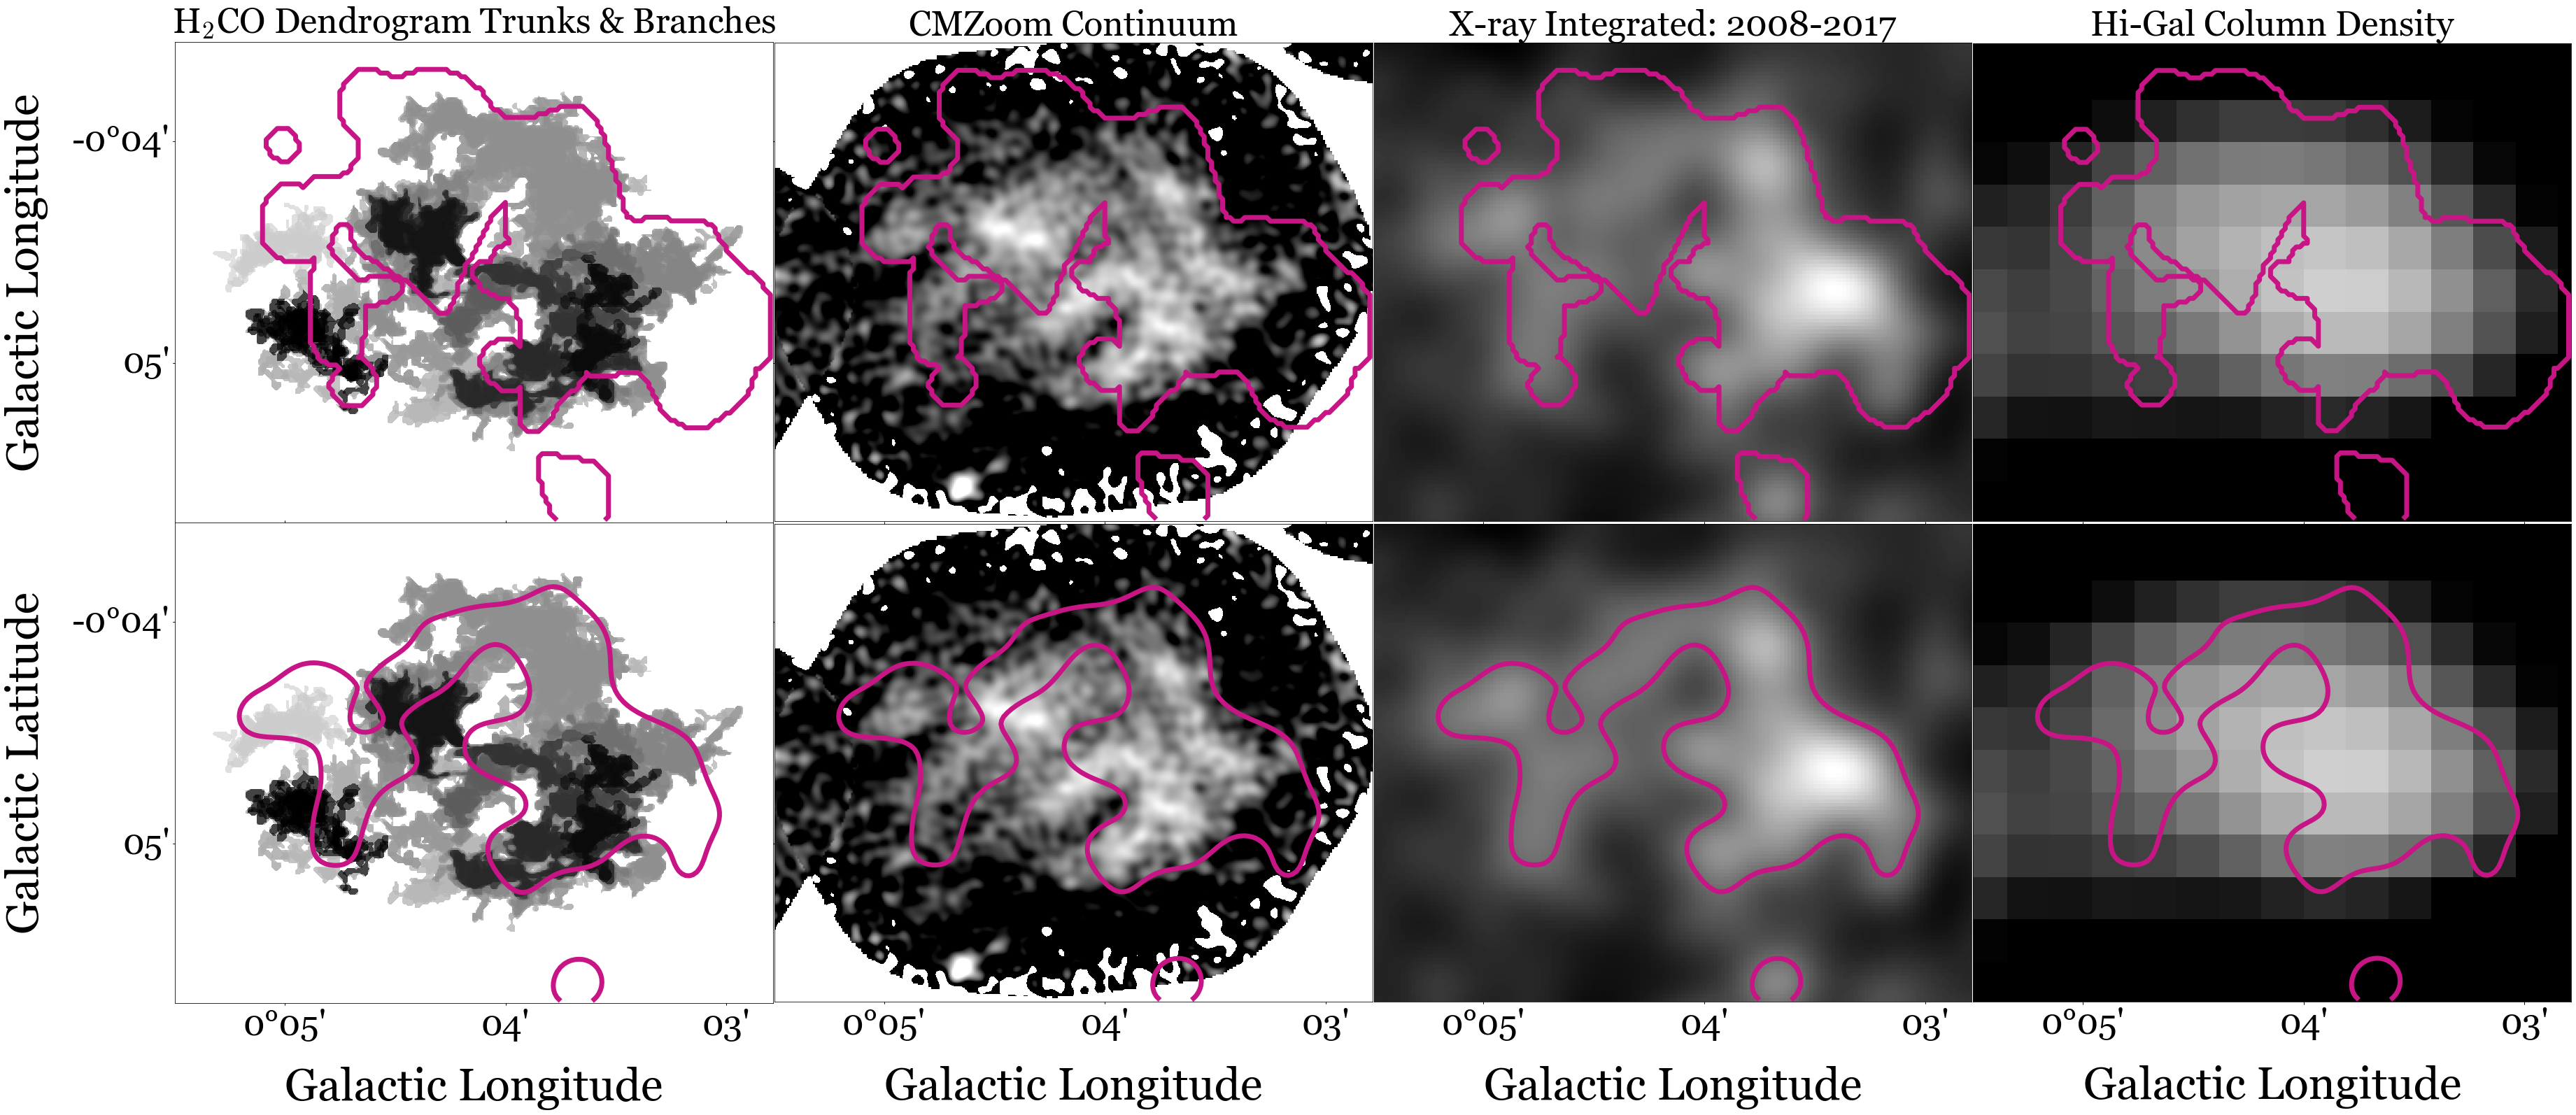

In [26]:
from astropy.visualization.wcsaxes import add_scalebar
from matplotlib.font_manager import FontProperties
from matplotlib.patches import Circle
fig_integrated, axes = plt.subplots(figsize=(51, 22))
matplotlib.rcParams['font.sans-serif'] = "georgia"
matplotlib.rcParams['mathtext.fontset'] = "cm"
matplotlib.rcParams['text.usetex'] = False
title_size = 65
tick_size = 50
label_size = 50
x_min = 590
x_max = 915
y_min = 140
y_max = 400
row = 2
col = 4
hersch_color = 'mediumvioletred'
xray_color = '#FF3361'
xray_color = '#C55770'
xray_color = 'mediumvioletred'
leaves = np.arange(len(trunks_idx_new))+1
cmap = cm.get_cmap('binary')
array = np.linspace(.2,1,len(trunks_idx_new))
color_leaves = cmap(array)

hdu_h2co = fits.open('non_pb_corrected_from_dan_G0.068-0.075.H2CO.218.2GHz_integrated.fits')
r1wcs = WCS(hdu_h2co[0])
middle_wcs = r1wcs

#cmzoom_data= np.nan_to_num(hdu_cmzoom.data, nan=1.0)
#h2co_data= np.nan_to_num(hdu_h2co[0].data, nan=0.0)

# Ensure hdus and projections arrays have 8 elements for 8 subplots
hdus = [hdu_h2co[0].data, hdu_cmzoom.data, xray_int, hdu_herschel.data,
        hdu_h2co[0].data, hdu_cmzoom.data, xray_int, hdu_herschel.data]  # Add more elements if needed
projections = [r1wcs, wcs_cmzoom, wcs_xray_2axis, wcs_herschel,
               r1wcs, wcs_cmzoom, wcs_xray_2axis, wcs_herschel]  # Add more projections
label_row=['xray','xray2']
middle_cube = hdus[1]
middle_wcs = wcs_cmzoom_cutout
titles = [r"H$_2$CO Dendrogram Trunks & Branches", 'CMZoom Continuum', 'X-ray Integrated: 2008-2017', 'Hi-Gal Column Density']  # Titles for each subplot

ra_min, dec_min = middle_wcs.all_pix2world(x_min, y_min, 0)
ra_max, dec_max = middle_wcs.all_pix2world(x_max, y_max, 0)
gc_distance = 8.17 * u.kpc
scalebar_length_03 = 0.3 * u.pc
scalebar_angle_03pc = (scalebar_length_03 / gc_distance).to(u.deg, equivalencies=u.dimensionless_angles())

count = 0
for i in range(col):
    for j in range(row):
        index = i + j * col  # This ensures the proper indexing for all 8 subplots
        ax = plt.subplot(row, col, index + 1, projection=projections[index])
        lon = ax.coords[0]
        lat = ax.coords[1]
        # Convert world coordinates to pixel coordinates for the center
        circle_center_pix = projections[index].all_world2pix(ra_min + (ra_max - ra_min) / 2, dec_min + (dec_max - dec_min) / 2, 0)
        # Convert the radius from degrees to pixels
        circle_radius_pix = (scalebar_angle_03pc / 2).to_value(u.deg) / projections[index].wcs.cdelt[0]
        
        #ax.plot_coord(max_hersch_pos, '*', c=hersch_color, markersize=50)
        #ax.plot_coord(max_xray_pos, '*', c=xray_color, markersize=50, linewidth=6)
        x_min_new, y_min_new = projections[index].all_world2pix(ra_min, dec_min, 0)
        x_max_new, y_max_new = projections[index].all_world2pix(ra_max, dec_max, 0)

        if index==0 or index==4:
            #ax.imshow(hdus[index],origin='lower',cmap='gray',vmin=0.6,vmax=4)
            for k in range(len(trunks_idx_new)):
                if k==0 or k==1:
                    trunk = 'dendrograms/trunk_idx_{}_mask.fits'.format(trunks_idx_new[k])
                else:
                    trunk = 'dendrograms/branches_idx_{}_mask.fits'.format(trunks_idx_new[k])
                hdu_trunk = fits.open(trunk)[0]
                wcs_trunk = WCS(hdu_trunk)
        
                for l in range(40):  # 247 is number of velocities for full H2CO, 40 for 34_70 KM/S
                    masked = np.where(hdu_trunk.data[l] != 1, hdu_trunk.data[l], np.nan)
                    ax.contourf(hdu_trunk.data[l], masked, levels=[.99, 1.01], alpha=0.6,colors=[color_leaves[k]])
            # ax.contour(hdu_trunk.data[i], masked, levels=[1], alpha=0.3)
                
            #circle=Circle(xy=(x_min_new+((x_max_new-x_min_new)/15),y_min_new+((y_max_new-y_min_new)/15)),radius=circle_radius_pix,angle=0,hatch='//',edgecolor='black',facecolor='none',linewidth=4)
            #add_scalebar(ax, scalebar_angle_03pc,color='black',corner='bottom left')
        elif index==1 or index==5:
            ax.imshow(hdus[index],norm=LogNorm(vmin=4e7,vmax=1.5e8),cmap='gray')
            #circle=Circle(xy=(x_min_new+((x_max_new-x_min_new)/15),y_min_new+((y_max_new-y_min_new)/15)),radius=circle_radius_pix,angle=0,hatch='//',edgecolor='black',facecolor='none',linewidth=4)
        elif index==2 or index==6:
            ax.imshow(hdus[index], origin='lower', cmap='gray')
            #circle=Circle(xy=(x_min_new+((x_max_new-x_min_new)/15),y_min_new+((y_max_new-y_min_new)/15)),radius=circle_radius_pix,angle=0,hatch='//',edgecolor='white',facecolor='none',linewidth=4)
        else:
            ax.imshow(hdus[i], norm='log', vmin=6e22,vmax=2e23,cmap='gray')
            #circle=Circle(xy=(x_min_new+((x_max_new-x_min_new)/15),y_min_new+((y_max_new-y_min_new)/15)),radius=circle_radius_pix,angle=0,hatch='//',edgecolor='white',facecolor='none',linewidth=4)
        if j == 0:  # Top-left plot (corner of the "L")
            ax.contour(hdu_monster_mask.data, levels=[1], transform=ax.get_transform(wcs_xray_2axis), colors=xray_color, linewidths=7)
            ax.set_title(titles[index], fontsize=label_size)
        if i == 0 and j == 0:
            # Show only the left and bottom ticks (L-shape)
            lat.set_ticks_visible(True)
            lon.set_ticks_visible(False)
            lat.set_ticklabel(size=tick_size)
            lon.set_ticklabel_visible(False)
            ax.set_xlabel(' ')
            ax.set_ylabel('Galactic Longitude', fontsize=title_size)
            lat.set_major_formatter('dd:mm')

        elif j == row - 1:  # Bottom row: show x-ticks only (bottom side)
            ax.contour(xray_int, levels=[1.3e-8], transform=ax.get_transform(wcs_xray_2axis), colors=xray_color, linewidths=7)
            lon.set_ticklabel(size=tick_size)
            ax.set_xlabel('Galactic Longitude', fontsize=title_size)
            lon.set_major_formatter('dd:mm')
            if i==0:
                lat.set_ticks_visible(True)
                lat.set_ticklabel(size=tick_size)
                ax.set_ylabel('Galactic Latitude', fontsize=title_size)
                lat.set_major_formatter('dd:mm')
            else:
                lat.set_ticks_visible(False)
                lat.set_ticklabel_visible(False)
                lat.set_axislabel('')
        elif i == 0:  # First column: show y-ticks only (left side)
            ax.set_ylabel('Galactic Latitude', fontsize=title_size)
            lat.set_ticklabel(size=tick_size)
            lat.set_major_formatter('dd:mm')
            lon.set_ticks_visible(False)
            lon.set_ticklabel_visible(False)
            lon.set_axislabel('')
        else:  # Other plots: hide ticks for the inner subplots
            lat.set_ticks_visible(False)
            lat.set_ticklabel_visible(False)
            lat.set_axislabel('')
            lon.set_ticks_visible(False)
            lon.set_ticklabel_visible(False)
            lon.set_axislabel('')
        ax.set_xlim(x_min_new, x_max_new)
        ax.set_ylim(y_min_new, y_max_new)  

        #ax.add_artist(circle)
        #ax.plot_coord(circle_center_pix[0],circle_center_pix[1], '*', c=hersch_color, markersize=50)
    plt.tight_layout(pad=0.2, w_pad=0.2, h_pad=0.05)


In [27]:
fig_integrated.savefig("integrated_with_dendro_trunks_branches.pdf", dpi=300, bbox_inches="tight")

In [54]:
fig_integrated.savefig("integrated.pdf", dpi=300, bbox_inches="tight")

/var/folders/8n/_rhj_p6j11j3hj9wn3tzy0280000gn/T/ipykernel_20746/1602460876.py:30: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(131, projection=r1wcs)


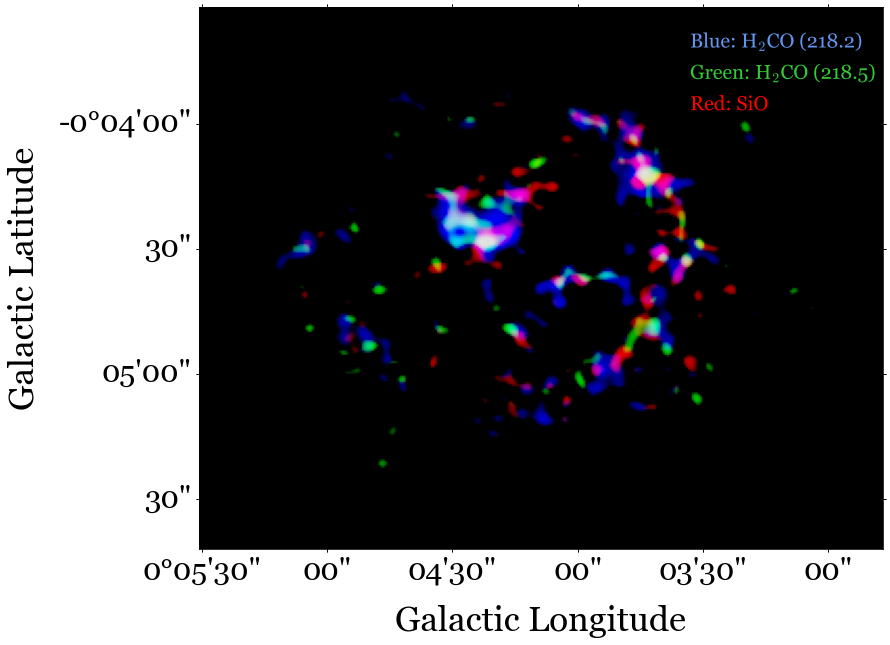

In [ ]:
fig_rgb, axes = plt.subplots(figsize=(30,25))
matplotlib.rcParams['font.sans-serif'] = "georgia" 

title_size=35
tick_size=30
label_size=20
x_min=0
x_max=328
y_min=0
y_max=260
# Extract coordinates from the second column for cropping
middle_cube = 'non_pb_corrected_from_dan_G0.068-0.075.SiO.217.1GHz_integrated.fits'
middle_wcs = r1wcs
projection = wcs_cmzoom
# Get the pixel limits for the second column

# Convert pixel coordinates to world coordinates for column 2
ra_min, dec_min = middle_wcs.all_pix2world(x_min, y_min, 0)
ra_max, dec_max = middle_wcs.all_pix2world(x_max, y_max, 0)

### Ok here's the fun part: we need to find a normalization for each color that makes it look
### good. This can be tricky, so try messing around with it for your images.
### Chances are, the default won't be great for you unless you're very lucky.
b = ImageNormalize(region1_f1_hdus[0].data,stretch=LogStretch(a=10),vmin=1.6, vmax=5.18, clip=True)(region1_f1_hdus[0].data) # LogStretch(a=50),vmin=0.8
g = ImageNormalize(region1_f2_hdus[0].data,stretch=LogStretch(a=10),vmin=1.6, vmax=3.03, clip=True)(region1_f2_hdus[0].data) # vmax=3.03
r = ImageNormalize(region1_f3_hdus[0].data,stretch=LogStretch(a=10),vmin=1.6, vmax=3.49, clip=True)(region1_f3_hdus[0].data) # vmax=3.49


#cmzoom with monster mask
ax = plt.subplot(131, projection=r1wcs)
lon = ax.coords[0]
lat = ax.coords[1]
### here's the call to actually make the rgb figure using make_lupton_rgb instead of aplpy
rgb_default = make_lupton_rgb(r, g, b,stretch=1,Q=1.0) # minimum=[0.24, 0.08, 0.24]
### Now actually show the grid using imshow
ax.imshow(rgb_default, origin='lower')


### Now I add just some nice path effects to make the label text legible
### I suggest changing out the frequency labels for the frequencies of your images
ax.text(s='Blue: H$_{2}$CO (218.2)',x=235,y=240,color='cornflowerblue',
        path_effects=[pe.withStroke(linewidth=2, foreground="black")],
        fontsize=label_size)
ax.text(s='Green: H$_{2}$CO (218.5)',x=235,y=225,color='limegreen',
        path_effects=[pe.withStroke(linewidth=2, foreground="black")],
        fontsize=label_size)
ax.text(s='Red: SiO',x=235,y=210,color='red',
        path_effects=[pe.withStroke(linewidth=2, foreground="black")],
        fontsize=label_size)
plt.tight_layout(pad=0.1, w_pad=0.5, h_pad=0.1)
ax.set_xlabel('Galactic Longitude',fontsize=title_size)
ax.set_ylabel('Galactic Latitude',fontsize=title_size)
lon.set_ticklabel(size=tick_size)
lat.set_ticklabel(size=tick_size)

